<a href="https://colab.research.google.com/github/sara1301/Bus-Station-Synchronization-OSPrj-2/blob/master/GAN_ML_prj_AI_sara_Ghavampour_9812762781.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## sara ghavampour 9812762781

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
descriminator_input_size= 784   ## 28 * 28
descriminator_output_size = 1
descriminator_hiddenLayers_size = 32 ### ????

generator_input_size= 100  ##  100 ???
generator_output_size = 784   ## 28 * 28
generator_hiddenLayers_size = 32 ### ????

In [ ]:
## donlowd data set + trainDataSet

from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True
)
print(train_data.data.size())


loaders = {
    'train': DataLoader(train_data, 
                        batch_size=210, 
                        shuffle=True),
}
loaders['train']

torch.Size([60000, 28, 28])


In [ ]:
### Discriminator class

##  Discriminator is  a classifier  
## hidden layers use leaky relu # has a neg slope for neg data (its not zero for neg data)
## all neurons are not activated with each other
###  cross entropy loss that comes inside a sigmoid function .in case your model's output layer is not wrapped with sigmoide to keep between 0 1  --> like softmax here i guess 
## cause BCE input should be betwwen 0 , 1
import torch.nn as nn   
import torch.nn.functional as func   ### ?????
class Discriminator (nn.Module):
  def __init__(self,descriminator_input_size,descriminator_hiddenLayers_size,descriminator_output_size):
      super(Discriminator,self).__init__()
      #### why linear ? y = w*x + b  A Feed-forward layer is a combination of a linear layer and a bias. It is capable of learning an offset and a rate of correlation
      self.hiddenLayer1 = nn.Linear(descriminator_input_size,descriminator_hiddenLayers_size*4)
      self.hiddenLayer2 = nn.Linear(descriminator_hiddenLayers_size*4, descriminator_hiddenLayers_size*2)
      self.hiddenLayer3 = nn.Linear(descriminator_hiddenLayers_size*2,descriminator_hiddenLayers_size)
        
        # final fully-connected layer
      self.hiddenLayer4 = nn.Linear(descriminator_hiddenLayers_size, descriminator_output_size)
        
        # dropout layer   randomly zeroes some of the elements of the input tensor with probability p
        #to avoid overfotting
      self.dropout = nn.Dropout(0.3)    #### p =0.3
        
        
  def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers
        x = func.leaky_relu(self.hiddenLayer1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)  ## ????
        x = func.leaky_relu(self.hiddenLayer2(x), 0.2)
        x = self.dropout(x)
        x = func.leaky_relu(self.hiddenLayer3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.hiddenLayer4(x)

        return out

In [ ]:
import torch.nn as nn 
import torch.nn.functional as func   ### ?????

class Generator(nn.Module):
  def __init__(self,generator_input_size,generator_hiddenLayers_size,generator_output_size) :
      super(Generator,self).__init__()

      self.hiddenLayer1 = nn.Linear(generator_input_size,generator_hiddenLayers_size)
      self.hiddenLayer2 = nn.Linear(generator_hiddenLayers_size, generator_hiddenLayers_size*2)
      self.hiddenLayer3 = nn.Linear(generator_hiddenLayers_size*2,generator_hiddenLayers_size*4)
        
        # final fully-connected layer
      self.hiddenLayer4 = nn.Linear(generator_hiddenLayers_size*4, generator_output_size)
        
        # dropout layer 
      self.dropout = nn.Dropout(0.3)    
        
        
  def forward(self, x):
        
        # all hidden layers
        x = func.leaky_relu(self.hiddenLayer1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)  ## ????
        x = func.leaky_relu(self.hiddenLayer2(x), 0.2)
        x = self.dropout(x)
        x = func.leaky_relu(self.hiddenLayer3(x), 0.2)
        x = self.dropout(x)
        # final layer

        ##### For binary classification, we typically use binary cross-entropy as the loss function:
        ###### when having sigmoid as the activation function of the nodes of the previous layer,
        # the weights of the node can either all increase or all decrease at the same time in a single step of gradient descent.

        #######

       #### ign of our inputs xᵢ can vary — some will be below zero and others will be larger than 0.
       #### Therefore, the direction of the updates are independent of one another. 
       ## d loss  = xi (a-y)     sigmoid is alrays +     but tanh is not
        out =torch.tanh(self.hiddenLayer4(x))

        return out


## create  Discriminator and Generator NN 
D =Discriminator(descriminator_input_size,descriminator_hiddenLayers_size,descriminator_output_size)
G = Generator(generator_input_size,generator_hiddenLayers_size,generator_output_size)

print(D)
print()
print(G)




Discriminator(
  (hiddenLayer1): Linear(in_features=784, out_features=128, bias=True)
  (hiddenLayer2): Linear(in_features=128, out_features=64, bias=True)
  (hiddenLayer3): Linear(in_features=64, out_features=32, bias=True)
  (hiddenLayer4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (hiddenLayer1): Linear(in_features=100, out_features=32, bias=True)
  (hiddenLayer2): Linear(in_features=32, out_features=64, bias=True)
  (hiddenLayer3): Linear(in_features=64, out_features=128, bias=True)
  (hiddenLayer4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [ ]:
## loss func
def real_img_loss(descriminator_outPut):
  epoch_size = descriminator_outPut.size(0)  ## number of images in this batch
  print('epoch_size ',epoch_size)
  loss = nn.BCEWithLogitsLoss(descriminator_outPut.squeeze(),torch.ones(epoch_size))
  return loss

####For binary classification, we typically use binary cross-entropy as the loss function

def fake_img_loss(descriminator_outPut):
  epoch_size = descriminator_outPut.size(0)  ## number of images in this batch
  print('epoch_size ',epoch_size)
  loss = nn.BCEWithLogitsLoss(descriminator_outPut.squeeze(),torch.zeros(epoch_size))
  return loss


In [ ]:
import pickle as pkl
import torch.optim as optim
import torch
import numpy as np

alpha = 0.002    ## learning rate ???
des_optimizer = optim.Adam(D.parameters(),alpha)
gen_optimuzer = optim.Adam(G.parameters(),alpha)

iterations = 50
samples = []
losses = []

sample_size=16  
sample_vector = np.random.uniform(-1, 1, size=(sample_size, generator_input_size))
sample_vector = torch.from_numpy(sample_vector).float()


D.train()
G.train()



for epoch in range(iterations):
    for batch_i, (real_images, _) in enumerate(loaders['train']):
        batch_size = real_images.size(0)
        real_images = real_images*2 - 1  ### -1 , 1    similar to tanh reason

        loss_function = nn.BCEWithLogitsLoss()
        ##### train descriminator
        real = D(real_images)
        real_loss = loss_function(real.squeeze(), torch.ones(real.size(0)))   ### 
        

        z = np.random.uniform(-1, 1, size=(batch_size, generator_input_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)  ## make a fake image
        
         ## calculate loss of this fake image by descriminator
        fake = D(fake_images)  
        fake_loss = loss_function(fake.squeeze(), torch.zeros(fake.size(0)))   
        
        des_optimizer.zero_grad()   #gradients to zero before starting to do backpropragation
        dis_loss = fake_loss + real_loss    ## loss for descriminator
        dis_loss.backward() ## back probagation
        des_optimizer.step()

         ##### train generator
        z = np.random.uniform(-1, 1, size=(batch_size, generator_input_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)

        fake = D(fake_images)
        
        
        gen_optimuzer.zero_grad()
        gen_loss = loss_function(fake.squeeze(), torch.ones(real.size(0)))
        gen_loss.backward()
        gen_optimuzer.step()

        if batch_i % 100 == 0:
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, iterations, dis_loss.item(), gen_loss.item()))
    
    losses.append((dis_loss.item(), gen_loss.item()))
    G.eval()
    samples_z = G(sample_vector)
    samples.append(samples_z)
    G.train()

with open('train_samples.pkl', 'wb') as p:
    pkl.dump(samples, p)



Epoch [    1/   50] | d_loss: 1.3903 | g_loss: 0.6276
Epoch [    1/   50] | d_loss: 1.3818 | g_loss: 1.2420
Epoch [    1/   50] | d_loss: 0.5736 | g_loss: 3.3856
Epoch [    2/   50] | d_loss: 0.6697 | g_loss: 2.7031
Epoch [    2/   50] | d_loss: 1.6374 | g_loss: 1.1146
Epoch [    2/   50] | d_loss: 1.3661 | g_loss: 1.2995
Epoch [    3/   50] | d_loss: 1.4071 | g_loss: 0.5983
Epoch [    3/   50] | d_loss: 1.0805 | g_loss: 1.4243
Epoch [    3/   50] | d_loss: 0.9059 | g_loss: 3.8862
Epoch [    4/   50] | d_loss: 1.1688 | g_loss: 0.9732
Epoch [    4/   50] | d_loss: 1.0718 | g_loss: 1.8913
Epoch [    4/   50] | d_loss: 1.2734 | g_loss: 1.2571
Epoch [    5/   50] | d_loss: 1.5133 | g_loss: 1.1569
Epoch [    5/   50] | d_loss: 0.8521 | g_loss: 2.8564
Epoch [    5/   50] | d_loss: 1.1580 | g_loss: 1.2749
Epoch [    6/   50] | d_loss: 1.2942 | g_loss: 0.7791
Epoch [    6/   50] | d_loss: 1.2929 | g_loss: 0.7953
Epoch [    6/   50] | d_loss: 0.9823 | g_loss: 1.4861
Epoch [    7/   50] | d_loss

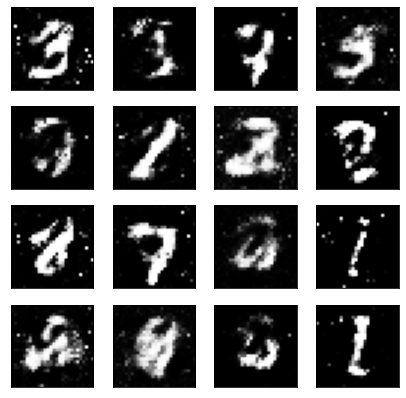

In [ ]:
import matplotlib.pyplot as plt

with open('train_samples.pkl', 'rb') as p:
    samples = pkl.load(p)

fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
for ax, img in zip(axes.flatten(), samples[-1]):
    img = img.detach()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

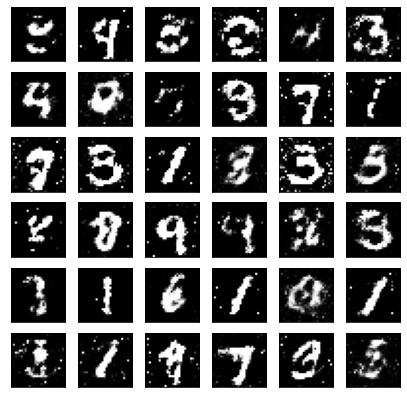

In [ ]:
#generate new samples
import matplotlib.pyplot as plt

sample_size=36
rand_z = np.random.uniform(-1, 1, size=(sample_size, generator_input_size))
rand_z = torch.from_numpy(rand_z).float()

rand_images = G(rand_z)

fig, axes = plt.subplots(figsize=(7,7), nrows=6, ncols=6, sharey=True, sharex=True)
for ax, img in zip(axes.flatten(), [rand_images][0]):
    img = img.detach()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')